In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.metrics import auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from tabular_models.utils import (evaluate_model, filter_column_name,
                                  get_freesurfer_columns, get_svm_explanations,
                                  get_xgboost_explanations, join_dfs)

from data_analysis_preparation.utils import (base_volumetric_columns,
                                             filter_df_by_problem)

### Load data

In [2]:
train_data_path = "../tabular_data/train_base.csv"
val_data_path = "../tabular_data/val_base.csv"
test_data_path = "../tabular_data/test_base.csv"
freesurfer_data_path = "../tabular_data/UCSFFSL_02_01_16_09Jun2023.csv"  # This is volumetric data only for ADNI1. It can be extended to ADNIGO, ADNI2 and ADNI3

In [3]:
df_train = pd.read_csv(train_data_path).dropna(subset=base_volumetric_columns)
df_val = pd.read_csv(val_data_path).dropna(subset=base_volumetric_columns)
df_test = pd.read_csv(test_data_path).dropna(subset=base_volumetric_columns)
df_freesurfer = pd.read_csv(freesurfer_data_path)

problems = ['AD vs CN', 'AD vs MCI', 'MCI vs CN', 'p-MCI vs np-MCI', 'AD vs MCI vs CN']

freesurfer_columns = get_freesurfer_columns(df_freesurfer)
joined_columns = base_volumetric_columns + freesurfer_columns

df_freesurfer_preprocessed = df_freesurfer[freesurfer_columns + ["IMAGEUID"]]
df_freesurfer_preprocessed = df_freesurfer_preprocessed.fillna(df_freesurfer_preprocessed.mean())

### Train, evaluate and explain models

In [4]:
dfs = {}
datasets = ["base", "freesurfer", "base + freesurfer"]
prepared_models = {}
rocs = {}
dfs_data = {}
explanations_xgboost = {}
explanations_svm = {}

for problem in problems:
    for dataset in datasets:
        print("--------------------------------------------------")
        print(f"Problem: {problem}, Dataset: {dataset}")
        _df_train = filter_df_by_problem(problem, df_train)
        _df_test = filter_df_by_problem(problem, df_test)
        _df_val = filter_df_by_problem(problem, df_val)
        _df_train = join_dfs(_df_train, df_freesurfer_preprocessed, joined_columns)
        _df_test = join_dfs(_df_test, df_freesurfer_preprocessed, joined_columns)
        _df_val = join_dfs(_df_val, df_freesurfer_preprocessed, joined_columns)
        train_y = _df_train["DX"].values
        test_y = _df_test["DX"].values
        val_y = _df_val["DX"].values

        if dataset == "freesurfer":
            columns = freesurfer_columns
        elif dataset == "base":
            columns = base_volumetric_columns
        elif dataset == "base + freesurfer":
                columns = joined_columns
        else:
            raise Exception("Dataset not found")

        train_X = _df_train[columns]
        val_X = _df_val[columns]
        test_X = _df_test[columns]

        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X.copy(deep=True))
        test_X = scaler.transform(test_X.copy(deep=True))
        val_X = scaler.transform(val_X.copy(deep=True))
        le = LabelEncoder()
        le.fit(train_y)
        train_y = le.transform(train_y)
        test_y = le.transform(test_y)
        val_y = le.transform(val_y)
        dfs_data[(problem, dataset)] = (train_X, train_y, val_X, val_y, test_X, test_y)
        print("Training SVM...")
        model_svm = SVC(probability=True)
        model_svm.fit(train_X, train_y)
        roc_svm = evaluate_model(model_svm, test_X, test_y, val_X, val_y)
        print("Training XGBoost...")
        model_xgboost = xgb.XGBClassifier()
        model_xgboost.fit(train_X, train_y)
        roc_xgb = evaluate_model(model_xgboost, test_X, test_y, val_X, val_y)
        prepared_models[(problem, dataset)] = (model_svm, model_xgboost)
        rocs[(problem, dataset)] = (roc_svm, roc_xgb)
        explanations_xgboost[(problem, dataset)] = get_xgboost_explanations(model_xgboost, columns)
        explanations_svm[(problem, dataset)] = get_svm_explanations(model_svm, columns, train_X, train_y)

--------------------------------------------------
Problem: AD vs CN, Dataset: base
Training SVM...
Accuracy on validation set: 0.906
Accuracy on test set: 0.768
Accuracy on validation + test set: 0.839
Balanced accuracy on validation set: 0.897
Balanced accuracy on test set: 0.753
Balanced accuracy on validation + test set: 0.828
ROC AUC on validation set: 0.897
ROC AUC on test set: 0.753
ROC AUC on validation + test set: 0.828
Training XGBoost...
Accuracy on validation set: 0.893
Accuracy on test set: 0.762
Accuracy on validation + test set: 0.829
Balanced accuracy on validation set: 0.886
Balanced accuracy on test set: 0.748
Balanced accuracy on validation + test set: 0.82
ROC AUC on validation set: 0.886
ROC AUC on test set: 0.748
ROC AUC on validation + test set: 0.82
--------------------------------------------------
Problem: AD vs CN, Dataset: freesurfer
Training SVM...
Accuracy on validation set: 0.906
Accuracy on test set: 0.887
Accuracy on validation + test set: 0.897
Balance

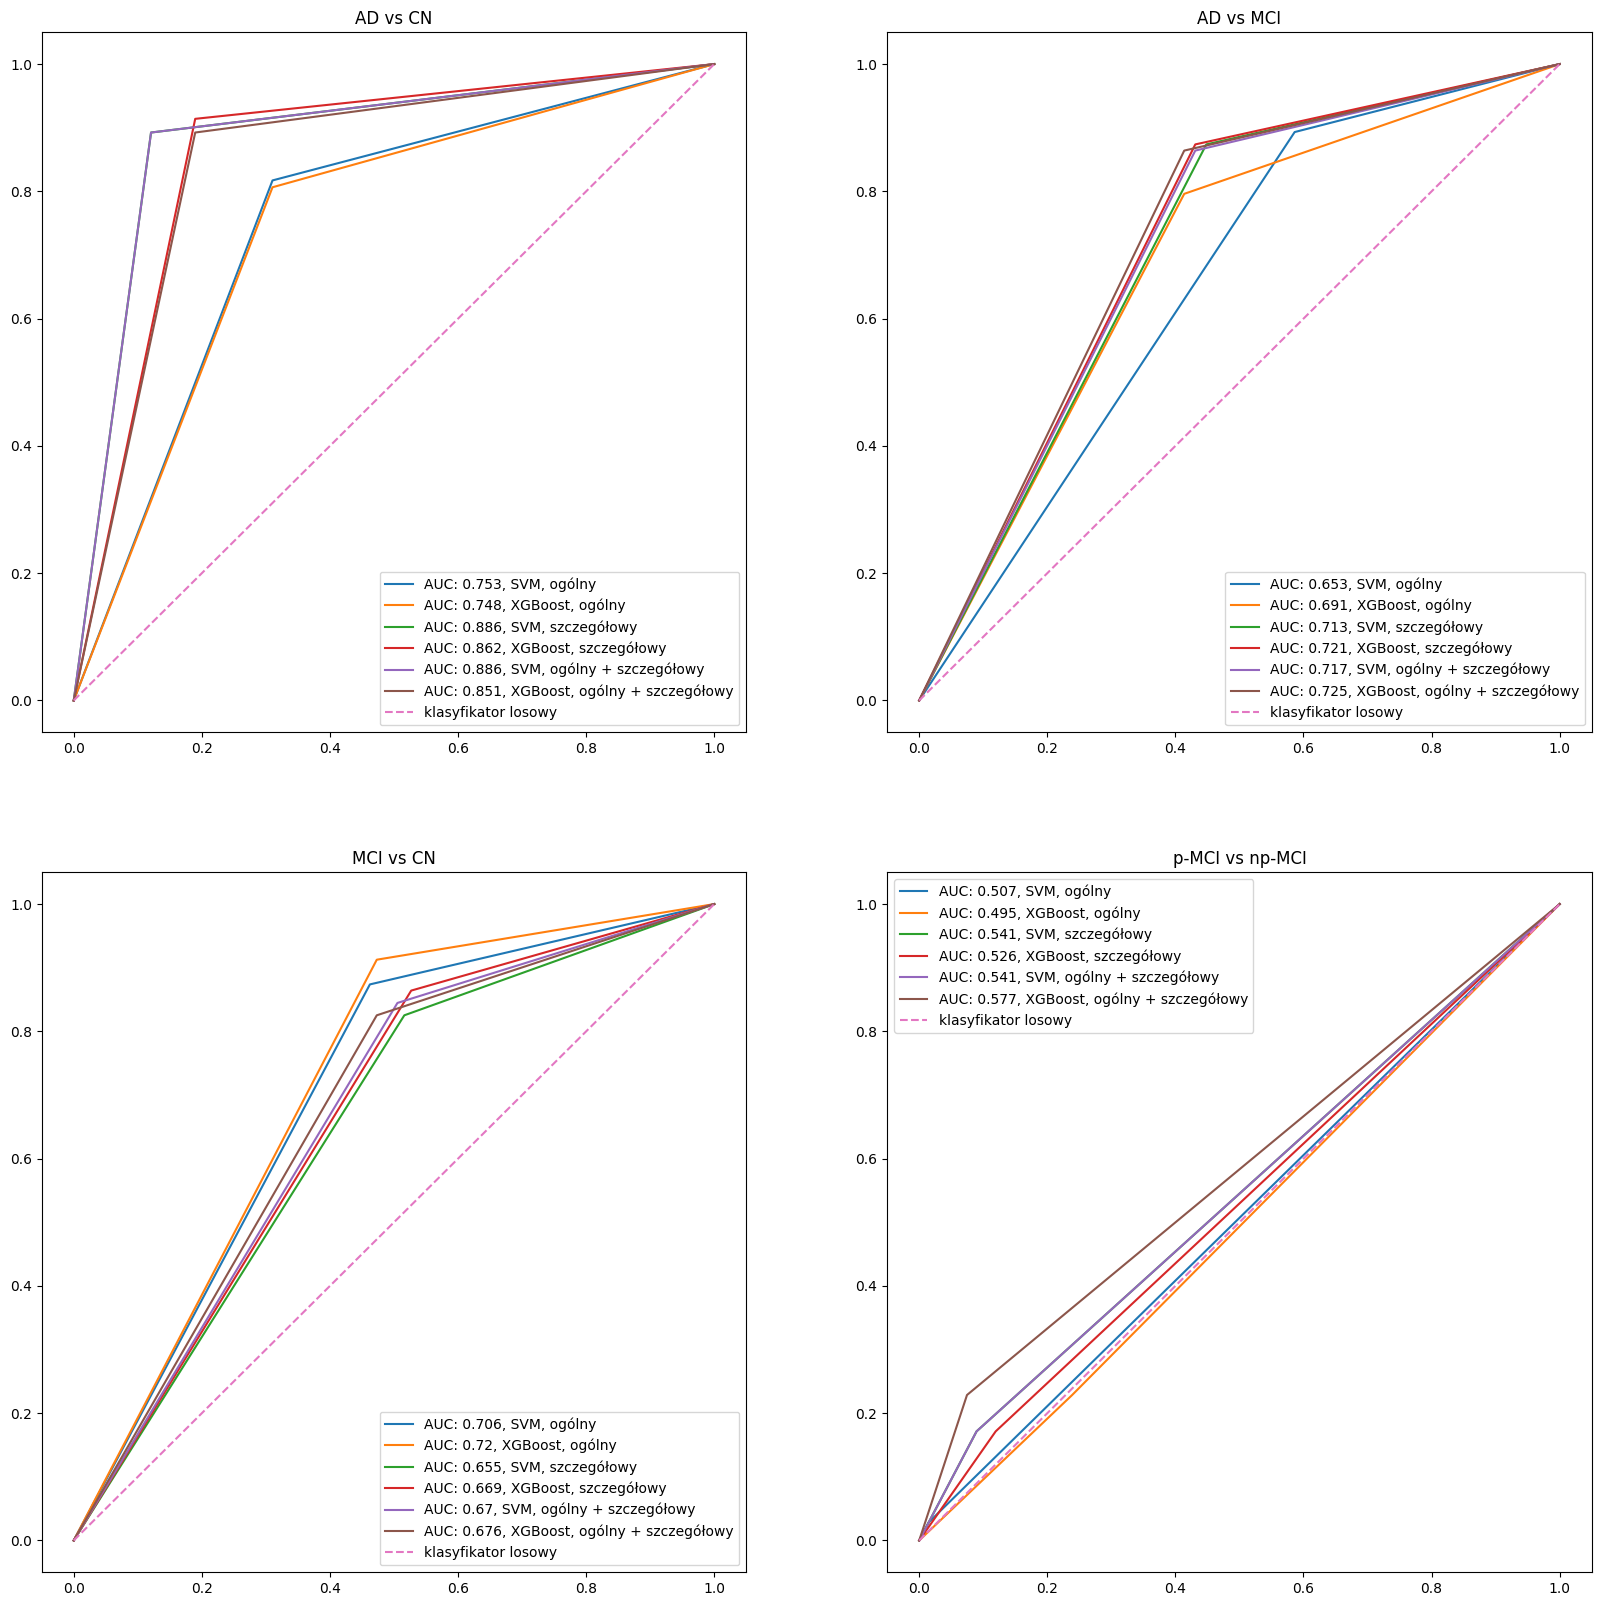

In [5]:
plt.figure(figsize=(20, 20))
for plot_idx, problem in enumerate([problem for problem in problems if problem != "AD vs MCI vs CN"]):
    plt.subplot(2, 2, plot_idx+1)
    plt.title(problem)
    roc_curves = [curve for _, curve in rocs.items() if _[0] == problem]
    for _, curve in rocs.items():
        if _[0] == problem:
            dataset = "ogólny" if _[1] == "base" else "szczegółowy" if _[1] == "freesurfer" else "ogólny + szczegółowy"
            plt.plot(curve[0][0], curve[0][1], label=f"AUC: {round(auc(curve[0][0], curve[0][1]),3)}, SVM, {dataset}")
            plt.plot(curve[1][0], curve[1][1], label=f"AUC: {round(auc(curve[1][0], curve[1][1]), 3)}, XGBoost, {dataset}")
    plt.plot([0, 1], [0, 1], linestyle='--', label="klasyfikator losowy")
    plt.legend()
plt.savefig("roc_curves_tabular.png")

### Plot explanations

In [6]:
with open("freesurfer_columns_sorted.txt", "r") as f:
    columns_freesurfer = f.read().splitlines()
columns_freesurfer_map = {phrase.split(" ")[0]: " ".join(filter_column_name(phrase).split(" ")[2:]) for phrase in columns_freesurfer}
columns_base_map = {col: col for col in base_volumetric_columns}
columns_freesurfer_map.update(columns_base_map)

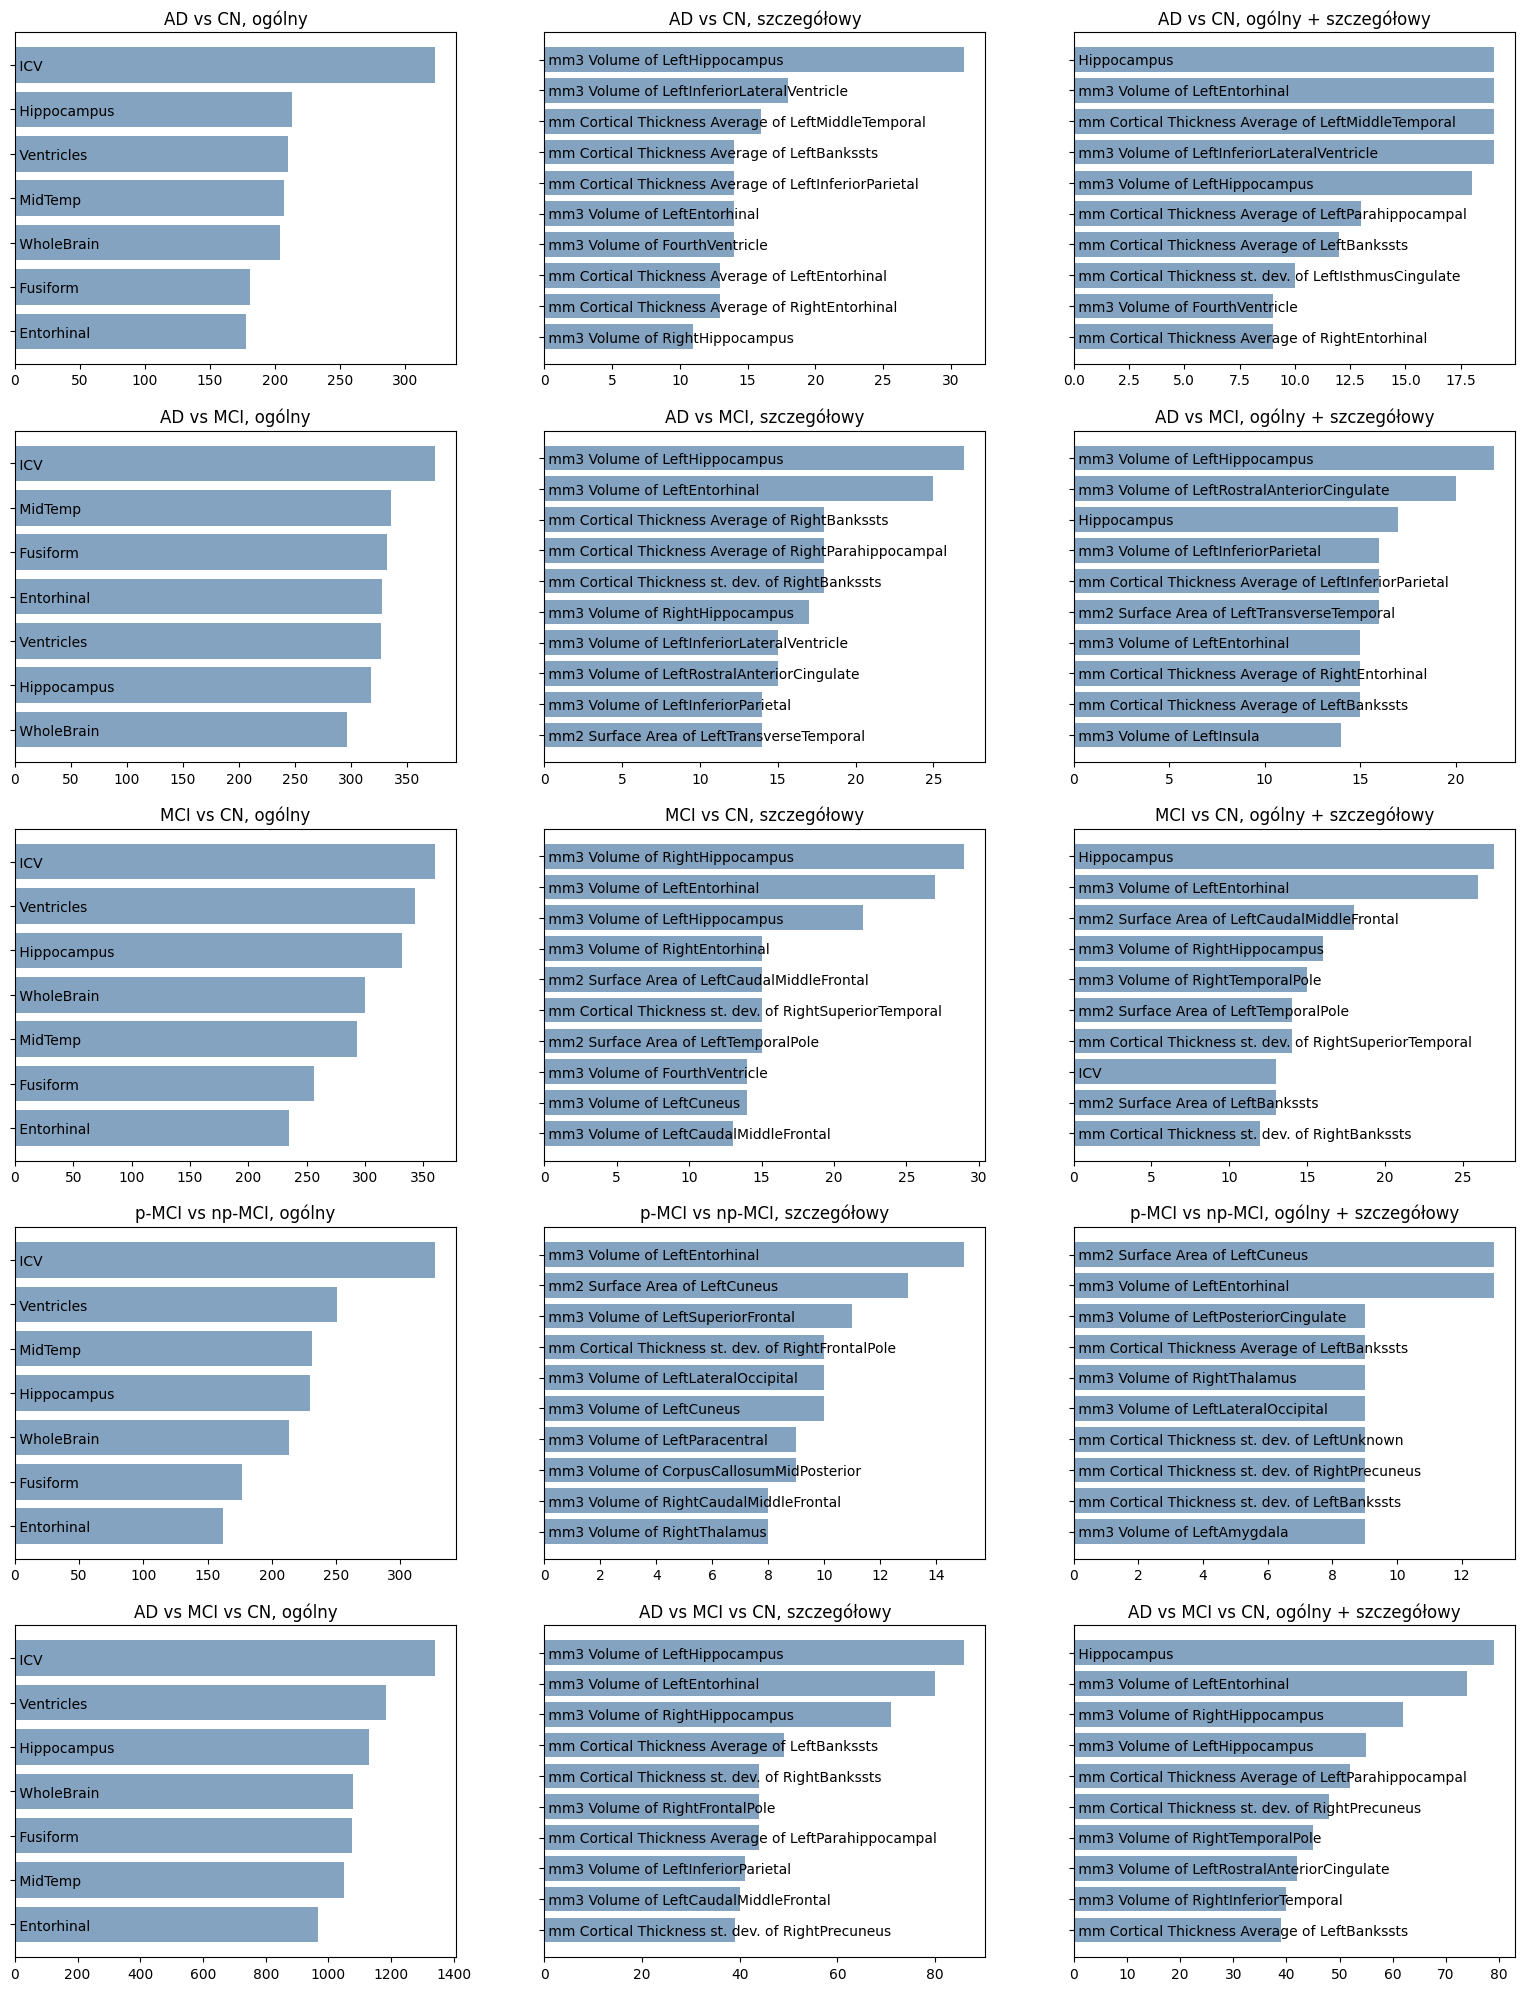

In [7]:
plt.figure(figsize=(25, 25))
for idx, ((problem, dataset), explanation_df) in enumerate(explanations_xgboost.items()):
    explanation_df["feature"] = explanation_df["feature"].map(columns_freesurfer_map, na_action="ignore")
    ax = plt.subplot(5, 3, idx+1)
    dataset = "ogólny" if dataset == "base" else "szczegółowy" if dataset == "freesurfer" else "ogólny + szczegółowy"
    plt.title(f"{problem}, {dataset}")
    g = plt.barh(explanation_df["feature"], explanation_df["importance"], color=(0.2, 0.4, 0.6, 0.6))
    plt.gca().invert_yaxis()
    plt.subplots_adjust(left=0.3)
    for p, text in zip(g.patches, explanation_df["feature"]):
        plt.text(0, p.get_y()+0.55*p.get_height(),
                 f" {text}",
                 ha='left', va='center')
    plt.tick_params(axis='both', which='both', bottom=True, top=False, labelbottom=True, right=False, left=True, labelleft=False)
    plt.savefig("explanations_xgboost.png")
plt.show()

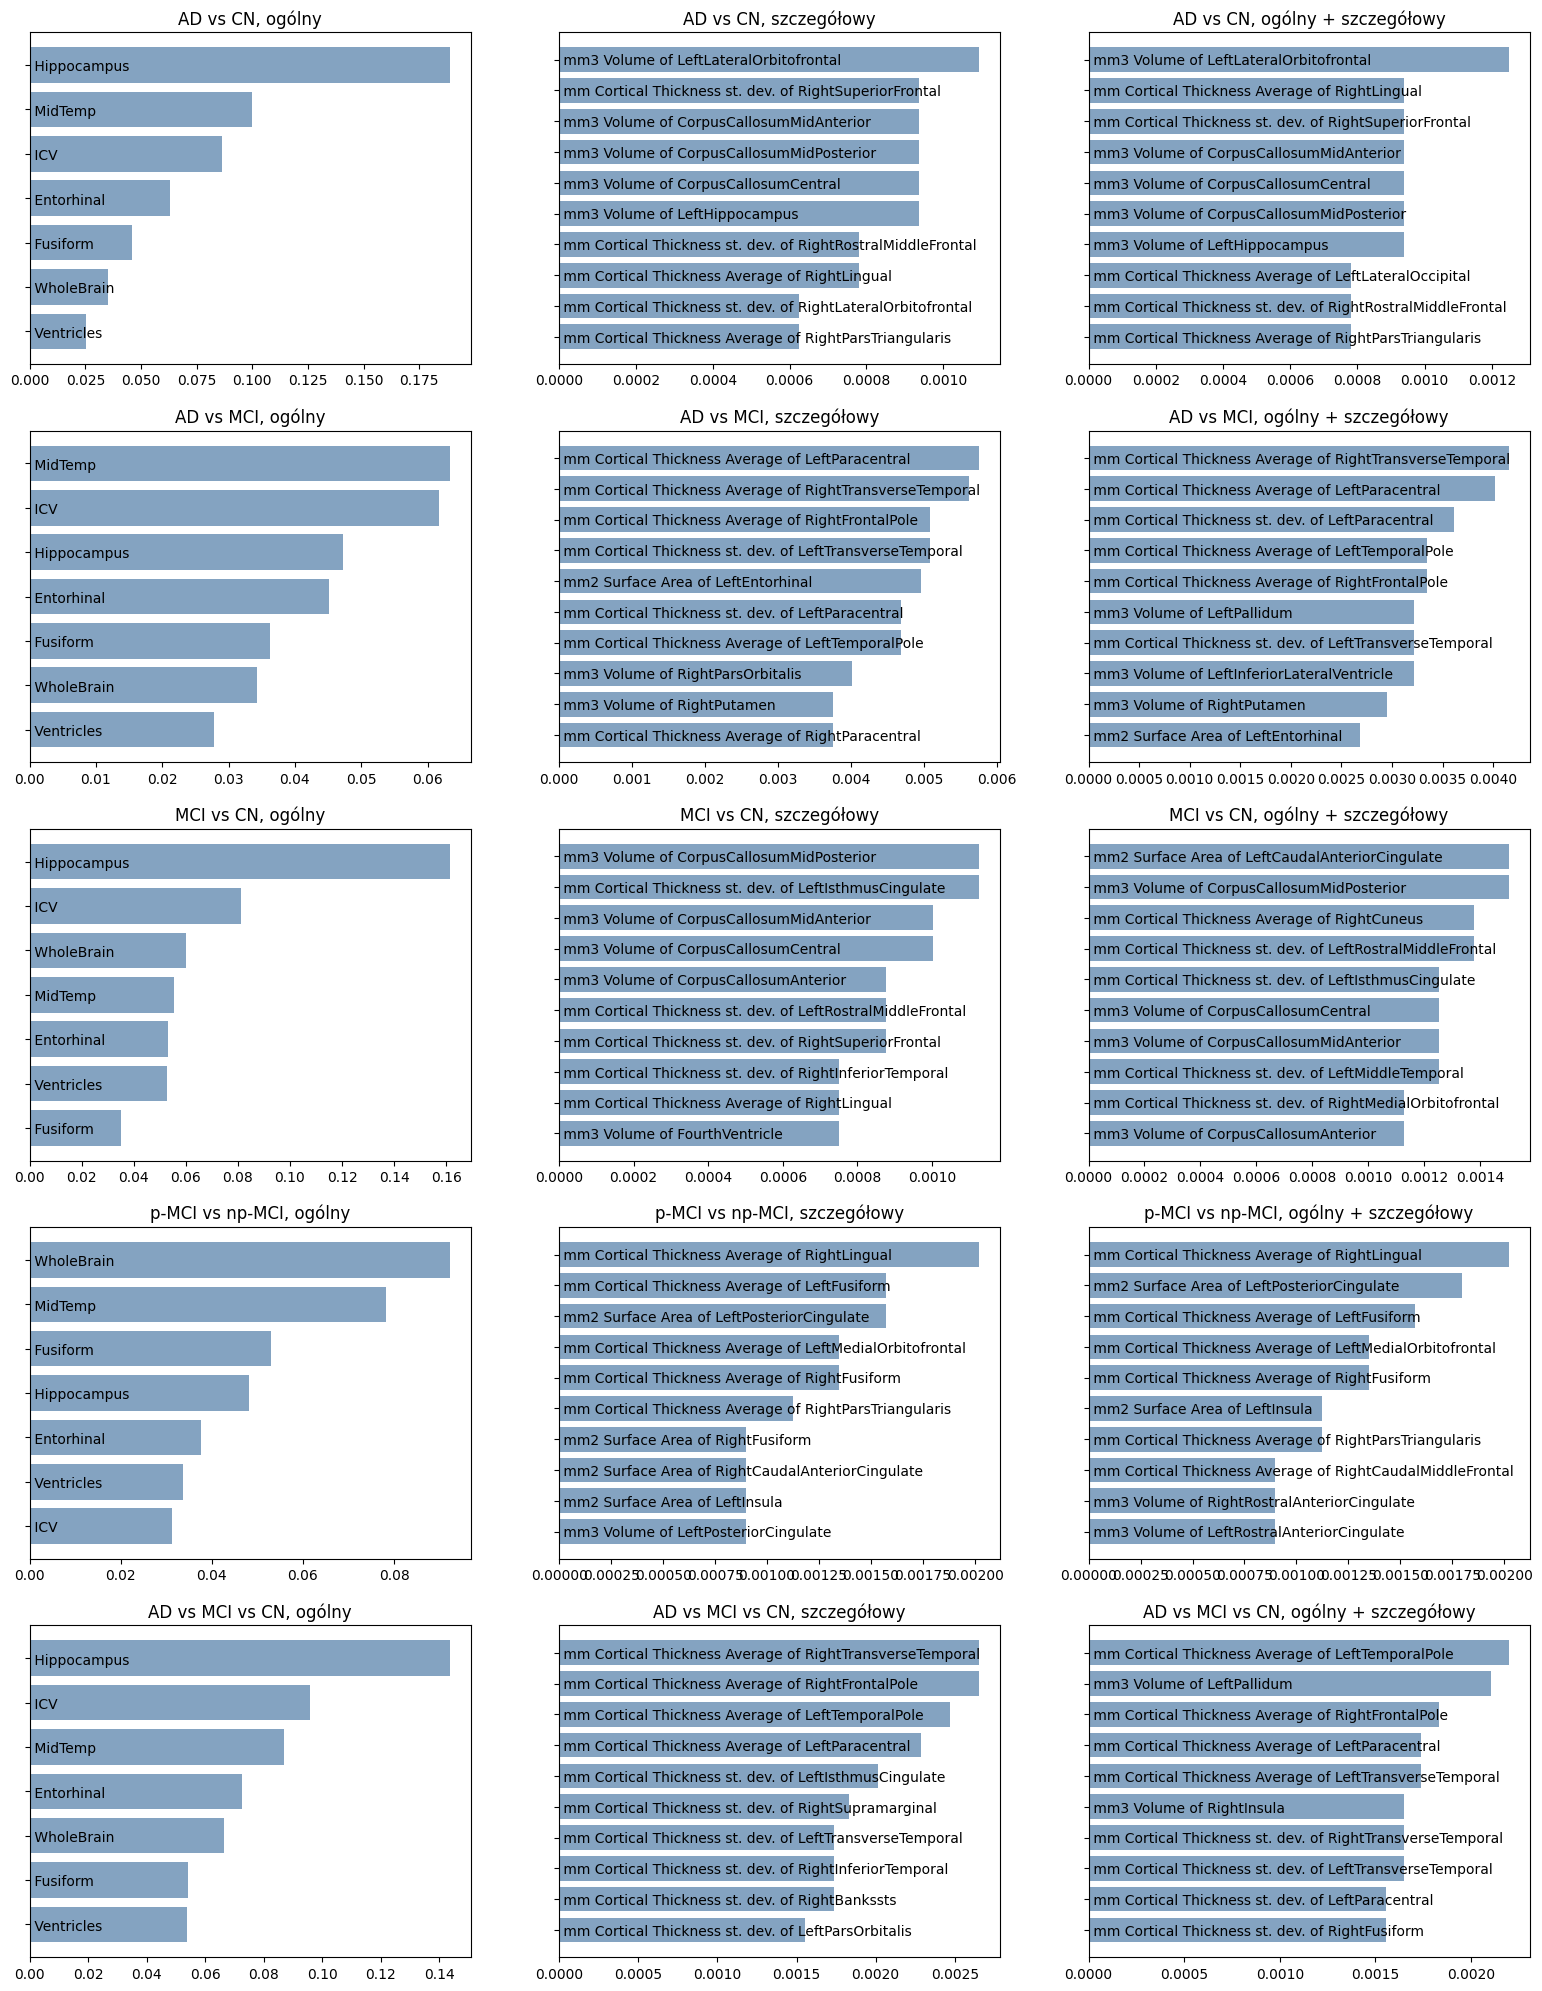

In [8]:
plt.figure(figsize=(25, 25))
for idx, ((problem, dataset), explanation_df) in enumerate(explanations_svm.items()):
    explanation_df["feature"] = explanation_df["feature"].map(columns_freesurfer_map, na_action="ignore")
    ax = plt.subplot(5, 3, idx+1)
    dataset = "ogólny" if dataset == "base" else "szczegółowy" if dataset == "freesurfer" else "ogólny + szczegółowy"
    plt.title(f"{problem}, {dataset}")
    g = plt.barh(explanation_df["feature"], explanation_df["importance"], color=(0.2, 0.4, 0.6, 0.6))
    plt.gca().invert_yaxis()
    plt.subplots_adjust(left=0.3)
    for p, text in zip(g.patches, explanation_df["feature"]):
        plt.text(0, p.get_y()+0.55*p.get_height(),
                 f" {text}",
                 ha='left', va='center')
    plt.tick_params(axis='both', which='both', bottom=True, top=False, labelbottom=True, right=False, left=True, labelleft=False)
    plt.savefig("explanations_SVM.png")
plt.show()